# Modeltraining and Quantization

In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, Normalize, Lambda, ToTensor

class VideoDataset(Dataset):
    def __init__(self, root_dir, num_frames=16, transform=None):
        """
        :param root_dir: Root directory containing subdirectories of videos, one for each class.
        :param num_frames: Number of frames to sample from each video.
        :param transform: A torchvision-style transform to apply to video frames.
        """
        self.root_dir = root_dir
        self.num_frames = num_frames
        self.transform = transform
        self.samples = []

        # Map class names to indices
        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        # Collect all video file paths and their class labels
        for cls_name in classes:
            cls_path = os.path.join(root_dir, cls_name)
            for video_name in os.listdir(cls_path):
                if video_name.endswith(('.avi', '.mp4', '.mkv')):
                    self.samples.append((os.path.join(cls_path, video_name), self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]

        # Load video with OpenCV
        cap = cv2.VideoCapture(video_path)
        frames = []
        success, frame = cap.read()
        while success:
            frames.append(frame)
            success, frame = cap.read()
        cap.release()

        # Handle case where the video has fewer frames than required
        if len(frames) < self.num_frames:
            # Option 1: Loop frames until enough are available
            frames = frames * (self.num_frames // len(frames) + 1)
            frames = frames[:self.num_frames]
        else:
            # OSample `num_frames` uniformly
            step = len(frames) // self.num_frames
            frames = frames[::step][:self.num_frames]

        # Apply transformations frame-wise
        if self.transform:
            # Convert frames to tensor, normalize and resize each frame
            transformed_frames = []
            for frame in frames:  # Iterate through frames (H, W, C) - use frames directly from OpenCV.
                frame = self.transform(frame)  # Apply the transform that already includes ToTensor()
                transformed_frames.append(frame)

            clip = torch.stack(transformed_frames).permute(1, 0, 2, 3)  # Stack back into (C, T, H, W)

        return clip, label

c:\Users\srsho\Projects\Smart-Surveillance-System\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model Evaluation

In [ ]:
import torch
import torch.quantization
from torchvision import models, transforms

video_transform = transforms.Compose([
    ToTensor(),
    Lambda(lambda x: x.float() / 255.0),
    transforms.Resize((112, 112)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize
                         std=[0.229, 0.224, 0.225])
])

train_dir = f"SCVD/SCVD_converted_sec_split/Train"
test_dir = f"SCVD/SCVD_converted_sec_split/Test"

test_dataset = VideoDataset(root_dir=test_dir, num_frames=16, transform=video_transform)
# Assuming dataset is already loaded as `dataset`
indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)


train_dataset = VideoDataset(root_dir=train_dir, num_frames=16, transform=video_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)


# Define a mapping of class indices to class names
class_names = {0: "Normal", 1: "Violence", 2: "Weapons"}

# Assuming your model is already loaded and prepared
model = models.video.r3d_18(pretrained=False)  # Initialize the model
model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))  # Adjust final layer

# Load the trained weights
model.load_state_dict(torch.load("VideoResNet2.pth"))

# Switch the model to evaluation mode
model.eval()

# Set the model for quantization
model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.quantization.prepare(model, inplace=True)

# Optionally, calibrate the model with a few batches of data
# Here you would need a DataLoader or sample data to run through the model
# For example, if you have a DataLoader `test_loader`, run a few batches:
for inputs, _ in test_loader:
    model(inputs)

# After calibration, convert the model to a quantized version
torch.quantization.convert(model, inplace=True)

# Save the quantized model
torch.save(model.state_dict(), "quantized_VideoResNet2.pth")


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import random

train_dir = f"SCVD/SCVD_converted_sec_split/Train"
test_dir = f"SCVD/SCVD_converted_sec_split/Test"

test_dataset = VideoDataset(root_dir=test_dir, num_frames=16, transform=video_transform)

# Assuming dataset is already loaded as `dataset`
indices = list(range(len(train_dataset)))
train_indices, val_indices_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Create DataLoaders
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(train_dataset, val_indices_indices)

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_subset, batch_size=16, shuffle=True, num_workers=0)


In [ ]:
# # Check if GPU is available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Move the model to the appropriate device
# model = model.to(device)

# for epoch in range(20):
#     model.train()
#     epoch_loss = 0.0 
#     correct = 0
#     total = 0

#     for i, data in enumerate(train_loader1):
#         inputs, labels = data

#         # Move inputs and labels to the same device as the model
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()

#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()

#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     epoch_accuracy = 100 * correct / total
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {epoch_accuracy:.2f}%')


In [9]:
print(len(train_loader))
print(len(test_loader))

535
134


In [12]:
import torch
import torchvision

# Load the pre-trained r3d_18 model
model = torchvision.models.video.r3d_18(pretrained=True)

num_classes = 3

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classes) # number of classes in your dataset


c:\Users\srsho\Projects\Smart-Surveillance-System\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\srsho\Projects\Smart-Surveillance-System\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train and Eval

In [14]:
import torch
import torch.nn as nn
from sklearn.metrics import average_precision_score
import numpy as np
from tqdm import tqdm
import json

# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

def main(model, train_loader, test_loader, n_epochs=100, num_classes=3, lr_scheduler=optimizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device=device)

    # Define loss functions
    ce_loss = nn.CrossEntropyLoss()

    # Track metrics
    history = {
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": [],
        "average_precision": [],
        "mean_average_precision": []
    }

    model.train()
    avgpr = 0.0
    best_accuracy = 0.0
    best_model_state_dict = None

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # Train loop
        for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
            data = data.to(device=device)
            targets = targets.to(device=device)
            optimizer.zero_grad()

            # Compute outputs
            output = model(data)

            # Compute loss
            loss = ce_loss(output, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            _, predicted = torch.max(output.data, 1)
            train_correct += (predicted == targets).sum().item()
            train_total += targets.size(0)
            train_loss += loss.item()

        # Calculate average losses and accuracy
        train_loss /= len(train_loader)
        train_acc = 100. * train_correct / train_total

        # Update learning rate
        lr_scheduler.step()

        # Validation loop
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        y_true = [[] for i in range(num_classes)]
        y_scores = [[] for i in range(num_classes)]

        with torch.no_grad():
            for batch_idx, (data, targets) in enumerate(tqdm(test_loader)):
                data = data.to(device=device)
                targets = targets.to(device=device)

                # Compute outputs
                scores = model(data)

                # Compute validation accuracy
                _, predicted = torch.max(scores.data, 1)
                val_correct += (predicted == targets).sum().item()
                val_total += targets.size(0)

                # Compute validation loss
                val_loss += ce_loss(scores, targets).item()

                # Convert targets to binary format using one-hot encoding
                targets_onehot = torch.eye(num_classes, device=device)[targets]

                # Append true and predicted labels for average precision
                for i in range(num_classes):
                    y_true[i].extend(targets_onehot[:, i].cpu().numpy().tolist())
                    y_scores[i].extend(scores[:, i].cpu().numpy().tolist())

            val_loss /= len(test_loader)
            val_acc = 100. * val_correct / val_total

        # Compute average precision for each class
        ap = []
        for i in range(num_classes):
            ap_i = average_precision_score(y_true[i], y_scores[i])
            ap.append(ap_i)

        # Compute mean average precision
        mAP = np.mean(ap) * 100

        # Save history for visualization
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)
        history["average_precision"].append(ap)
        history["mean_average_precision"].append(mAP)

        # Save the best model
        save_path = f"{type(model).__name__}_best.pth"
        if mAP > avgpr and val_acc > best_accuracy:
            torch.save(model.state_dict(), save_path)
            avgpr = mAP
            best_loss = train_loss
            best_accuracy = val_acc
            best_model_state_dict = model.state_dict()

        print(f"Epoch {epoch}/{n_epochs}: Train Loss: {train_loss:.4f} || Train Acc: {train_acc:.2f}% || "
              f"Val Loss: {val_loss:.4f} || Val Acc: {val_acc:.2f}% || mAP: {mAP:.4f}%")

    # Save history to JSON for further analysis
    with open("training_history.json", "w") as f:
        json.dump(history, f)

    return model, history, best_loss, best_accuracy, avgpr


model, history, best_loss, best_accuracy, avgpr = main(model, train_loader, test_loader, num_classes=3, n_epochs=30)

print(best_loss, best_accuracy, avgpr)


100%|██████████| 34/34 [01:34<00:00,  2.78s/it]


Epoch 1/30: Train Loss: 0.9151 || Train Acc: 57.22% || Val Loss: 0.8251 || Val Acc: 64.30% || mAP: 66.6122%


100%|██████████| 34/34 [01:34<00:00,  2.77s/it]


Epoch 2/30: Train Loss: 0.8268 || Train Acc: 63.07% || Val Loss: 0.8064 || Val Acc: 65.79% || mAP: 69.3720%


100%|██████████| 34/34 [01:34<00:00,  2.78s/it]


Epoch 3/30: Train Loss: 0.7931 || Train Acc: 63.96% || Val Loss: 0.8377 || Val Acc: 60.37% || mAP: 71.0357%


100%|██████████| 34/34 [01:33<00:00,  2.76s/it]


Epoch 4/30: Train Loss: 0.7539 || Train Acc: 67.41% || Val Loss: 0.7599 || Val Acc: 65.98% || mAP: 71.7837%


100%|██████████| 34/34 [01:34<00:00,  2.77s/it]


Epoch 5/30: Train Loss: 0.7372 || Train Acc: 68.63% || Val Loss: 0.7307 || Val Acc: 69.16% || mAP: 72.9024%


100%|██████████| 34/34 [01:35<00:00,  2.80s/it]


Epoch 6/30: Train Loss: 0.7036 || Train Acc: 70.45% || Val Loss: 0.7560 || Val Acc: 65.05% || mAP: 73.2455%


100%|██████████| 34/34 [01:32<00:00,  2.73s/it]


Epoch 7/30: Train Loss: 0.6927 || Train Acc: 70.55% || Val Loss: 0.7097 || Val Acc: 69.91% || mAP: 74.4108%


100%|██████████| 34/34 [01:31<00:00,  2.70s/it]


Epoch 8/30: Train Loss: 0.6701 || Train Acc: 72.00% || Val Loss: 0.7007 || Val Acc: 68.97% || mAP: 74.6093%


100%|██████████| 34/34 [01:33<00:00,  2.74s/it]


Epoch 9/30: Train Loss: 0.6499 || Train Acc: 73.31% || Val Loss: 0.7048 || Val Acc: 71.40% || mAP: 75.3019%


100%|██████████| 34/34 [01:31<00:00,  2.69s/it]


Epoch 10/30: Train Loss: 0.6346 || Train Acc: 75.18% || Val Loss: 0.6841 || Val Acc: 71.59% || mAP: 75.7041%


100%|██████████| 34/34 [01:33<00:00,  2.74s/it]


Epoch 11/30: Train Loss: 0.6276 || Train Acc: 74.33% || Val Loss: 0.6694 || Val Acc: 71.78% || mAP: 76.0326%


100%|██████████| 34/34 [01:31<00:00,  2.70s/it]


Epoch 12/30: Train Loss: 0.6140 || Train Acc: 74.57% || Val Loss: 0.6702 || Val Acc: 71.40% || mAP: 76.0760%


100%|██████████| 34/34 [01:32<00:00,  2.73s/it]


Epoch 13/30: Train Loss: 0.6065 || Train Acc: 75.27% || Val Loss: 0.6588 || Val Acc: 71.03% || mAP: 76.2236%


100%|██████████| 34/34 [01:31<00:00,  2.69s/it]


Epoch 14/30: Train Loss: 0.5934 || Train Acc: 77.23% || Val Loss: 0.7092 || Val Acc: 68.41% || mAP: 76.3722%


100%|██████████| 34/34 [01:31<00:00,  2.70s/it]


Epoch 15/30: Train Loss: 0.5909 || Train Acc: 76.53% || Val Loss: 0.6483 || Val Acc: 72.34% || mAP: 76.8573%


100%|██████████| 34/34 [01:31<00:00,  2.69s/it]


Epoch 16/30: Train Loss: 0.5821 || Train Acc: 76.48% || Val Loss: 0.6971 || Val Acc: 69.16% || mAP: 77.0885%


100%|██████████| 34/34 [01:33<00:00,  2.76s/it]


Epoch 17/30: Train Loss: 0.5757 || Train Acc: 76.91% || Val Loss: 0.6458 || Val Acc: 71.59% || mAP: 77.5349%


100%|██████████| 34/34 [01:31<00:00,  2.69s/it]


Epoch 18/30: Train Loss: 0.5759 || Train Acc: 75.74% || Val Loss: 0.6468 || Val Acc: 71.59% || mAP: 77.4644%


100%|██████████| 34/34 [01:31<00:00,  2.68s/it]


Epoch 19/30: Train Loss: 0.5479 || Train Acc: 79.29% || Val Loss: 0.6786 || Val Acc: 70.47% || mAP: 77.6646%


100%|██████████| 34/34 [01:32<00:00,  2.73s/it]


Epoch 20/30: Train Loss: 0.5503 || Train Acc: 78.45% || Val Loss: 0.6489 || Val Acc: 70.47% || mAP: 77.9685%


100%|██████████| 34/34 [01:31<00:00,  2.68s/it]


Epoch 21/30: Train Loss: 0.5386 || Train Acc: 79.99% || Val Loss: 0.6423 || Val Acc: 72.34% || mAP: 78.1551%


100%|██████████| 34/34 [01:31<00:00,  2.70s/it]


Epoch 22/30: Train Loss: 0.5322 || Train Acc: 80.04% || Val Loss: 0.6290 || Val Acc: 73.83% || mAP: 78.1120%


100%|██████████| 34/34 [01:32<00:00,  2.71s/it]


Epoch 23/30: Train Loss: 0.5265 || Train Acc: 80.55% || Val Loss: 0.6182 || Val Acc: 73.08% || mAP: 78.4621%


100%|██████████| 34/34 [01:32<00:00,  2.71s/it]


Epoch 24/30: Train Loss: 0.5227 || Train Acc: 78.92% || Val Loss: 0.6166 || Val Acc: 72.71% || mAP: 78.4233%


100%|██████████| 34/34 [01:31<00:00,  2.70s/it]


Epoch 25/30: Train Loss: 0.5224 || Train Acc: 79.48% || Val Loss: 0.6375 || Val Acc: 72.15% || mAP: 78.4963%


100%|██████████| 34/34 [01:34<00:00,  2.77s/it]


Epoch 26/30: Train Loss: 0.5143 || Train Acc: 80.18% || Val Loss: 0.6604 || Val Acc: 70.28% || mAP: 78.5066%


100%|██████████| 34/34 [01:36<00:00,  2.84s/it]


Epoch 27/30: Train Loss: 0.5074 || Train Acc: 80.46% || Val Loss: 0.6133 || Val Acc: 73.64% || mAP: 78.7231%


100%|██████████| 34/34 [01:33<00:00,  2.74s/it]


Epoch 28/30: Train Loss: 0.5033 || Train Acc: 81.07% || Val Loss: 0.6139 || Val Acc: 73.08% || mAP: 78.7993%


100%|██████████| 34/34 [01:30<00:00,  2.66s/it]


Epoch 29/30: Train Loss: 0.4979 || Train Acc: 81.21% || Val Loss: 0.6754 || Val Acc: 71.21% || mAP: 78.7302%


100%|██████████| 34/34 [01:30<00:00,  2.67s/it]

Epoch 30/30: Train Loss: 0.4908 || Train Acc: 80.69% || Val Loss: 0.6151 || Val Acc: 73.08% || mAP: 78.6097%
0.5322120763472656 73.83177570093459 78.11196170092694


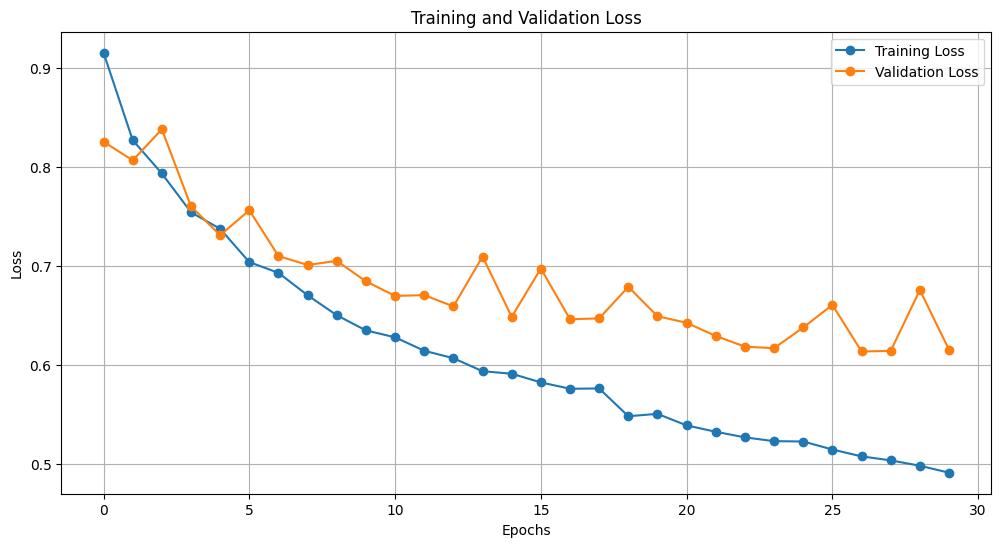

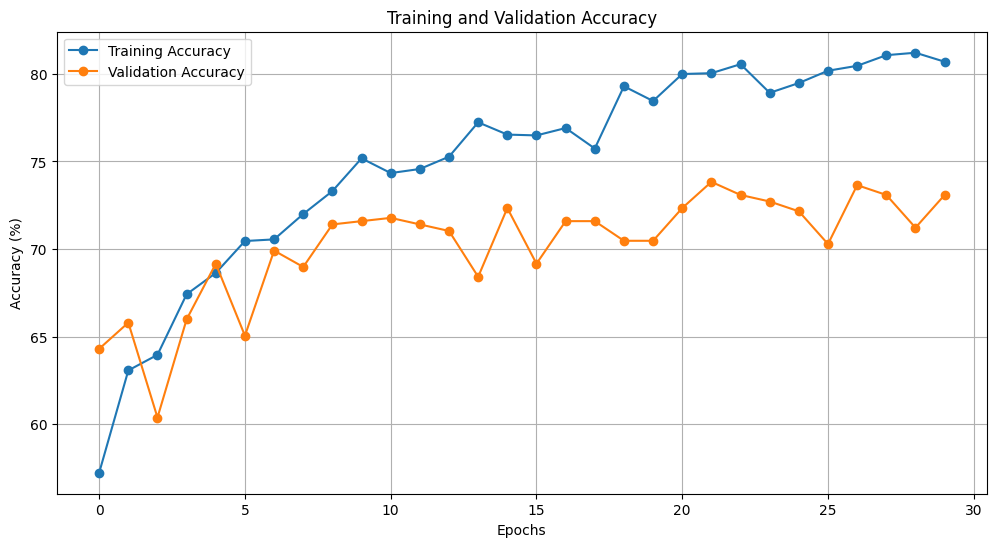

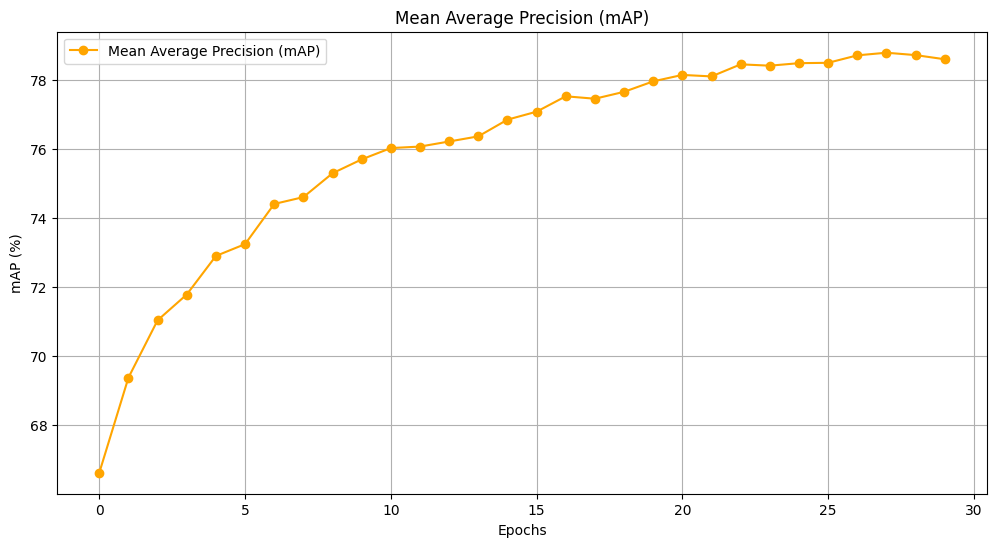

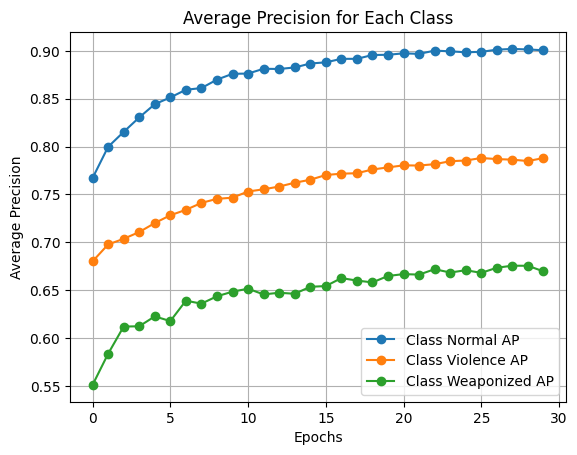

In [ ]:
import matplotlib.pyplot as plt
import json

# Load training history from JSON file
with open("training_history.json", "r") as f:
    history = json.load(f)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history["train_loss"], label="Training Loss", marker="o")
plt.plot(history["val_loss"], label="Validation Loss", marker="o")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history["train_accuracy"], label="Training Accuracy", marker="o")
plt.plot(history["val_accuracy"], label="Validation Accuracy", marker="o")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Mean Average Precision (mAP)
plt.figure(figsize=(12, 6))
plt.plot(history["mean_average_precision"], label="Mean Average Precision (mAP)", marker="o", color="orange")
plt.title("Mean Average Precision (mAP)")
plt.xlabel("Epochs")
plt.ylabel("mAP (%)")
plt.legend()
plt.grid(True)
plt.show()

# Average Precision for each class
num_classes = {'Normal': 0, 'Violence': 1, 'Weaponized': 2}  # Number of classes
for i in num_classes:
    ap_class = [epoch_ap[num_classes[i]] for epoch_ap in history["average_precision"]]
    plt.plot(ap_class, label=f"Class {i} AP", marker="o")

plt.title("Average Precision for Each Class")
plt.xlabel("Epochs")
plt.ylabel("Average Precision")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch.optim as optim
from sklearn.metrics import average_precision_score, confusion_matrix
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import json

def train_and_evaluate_model(model, train_loader, test_loader, num_classes=3, n_epochs=50, save_path='best_model.pth'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Define loss function and optimizer
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    
    # Track metrics
    history = {
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": [],
        "average_precision": [],
        "mean_average_precision": [],
    }
    
    best_val_accuracy = 0.0  # Initialize best validation accuracy to track improvements
    best_loss = float('inf')  # Initialize best validation loss
    best_model_wts = None  # Store the best model weights
    
    # Initialize lists to accumulate true and predicted labels for confusion matrix
    all_y_true = []
    all_y_pred = []
    
    # Training loop
    for epoch in range(1, n_epochs + 1):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # Train the model
        for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
            data = data.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            
            output = model(data)
            loss = ce_loss(output, targets)
            
            loss.backward()
            optimizer.step()
            
            # Calculate training accuracy
            _, predicted = torch.max(output.data, 1)
            train_correct += (predicted == targets).sum().item()
            train_total += targets.size(0)
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_acc = 100. * train_correct / train_total
        
        # Update the learning rate
        lr_scheduler.step()

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        y_true = []
        y_pred = []

        with torch.no_grad():
            for batch_idx, (data, targets) in enumerate(tqdm(test_loader)):
                data = data.to(device)
                targets = targets.to(device)

                # Compute the output
                scores = model(data)

                # Compute validation accuracy
                _, predicted = torch.max(scores.data, 1)
                val_correct += (predicted == targets).sum().item()
                val_total += targets.size(0)

                # Compute validation loss
                val_loss += ce_loss(scores, targets).item()

                # Store true and predicted labels for confusion matrix
                y_true.extend(targets.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

            val_loss /= len(test_loader)
            val_acc = 100. * val_correct / val_total

        # Compute average precision for each class
        ap = []
        for i in range(num_classes):
            ap_i = average_precision_score(y_true == i, np.array(y_pred) == i)
            ap.append(ap_i)

        # Compute mean average precision
        mAP = np.mean(ap) * 100

        # Save the training history
        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)
        history["average_precision"].append(ap)
        history["mean_average_precision"].append(mAP)

        # Print training and validation statistics
        print(f"Epoch {epoch}/{n_epochs}: Train Loss: {train_loss:.4f} || Train Acc: {train_acc:.2f}% || "
              f"Val Loss: {val_loss:.4f} || Val Acc: {val_acc:.2f}% || mAP: {mAP:.4f}%")

        # Append current epoch's true and predicted labels to the accumulated lists
        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)

        # Save model weights if validation accuracy improves
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_loss = val_loss
            best_model_wts = model.state_dict()  # Save the best model weights
            torch.save(model.state_dict(), save_path)  # Save the model checkpoint

    # Compute overall confusion matrix
    overall_cm = confusion_matrix(all_y_true, all_y_pred, labels=np.arange(num_classes))

    # Save history to JSON for further analysis
    with open("training_history.json", "w") as f:
        json.dump(history, f)

    # Plot overall confusion matrix after all epochs
    plot_confusion_matrix(overall_cm, num_classes)

    return model, history, best_loss, best_accuracy, ap, overall_cm

def plot_confusion_matrix(cm, num_classes):
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.title('Overall Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Example usage
model, history, best_loss, best_accuracy, ap, overall_cm = train_and_evaluate_model(model, train_loader, test_loader, num_classes=3, n_epochs=50)

print(f"Best Validation Loss: {best_loss}, Best Validation Accuracy: {best_accuracy}, Mean Average Precision: {np.mean(ap)}")

